In [2]:
from scipy.io import wavfile
import matplotlib.pyplot as plt
import IPython.display as ipd
import numpy as np

from librosa.util import buf_to_float
from librosa.display import waveplot, specshow
from librosa import amplitude_to_db, stft, power_to_db

In [3]:
fft_size = 512
sample_rate = 16000
n_mels = 64

In [4]:
def play_wav(f_name):
    sr, wav_data = wavfile.read(f_name)
    ipd.display(ipd.Audio(f_name, rate=sr))
    
    return wav_data
    
def show_wav(f_name):
    sr, wav_data = wavfile.read(f_name)
    wav_data = buf_to_float(wav_data)
    plt.figure(figsize=(14, 4))
    plt.grid()
    waveplot(wav_data, sr=sr)
    
    return wav_data
    
def show_spec(f_name):
    sr, wav_data = wavfile.read(f_name)
    wav_data = buf_to_float(wav_data)
    spec = stft(wav_data, n_fft=fft_size)
    spec_db = amplitude_to_db(abs(spec))
    plt.figure(figsize=(14, 8))
    specshow(spec_db, sr=sr, x_axis='time', y_axis='hz')
    
    return spec

Обратное преобразование Фурье (представляем сигнал в виде суммы гармоник): $$ x_n = {{1}\over{N}}\sum\limits_{k=0}^{N-1} X_k e^{{{2\pi i}\over{N}} k n} $$

Прямое преобразование Фурье: $$ X_k = \sum\limits_{n=0}^{N-1} x_n e^{-{{2\pi i}\over{N}} k n} $$

Оконное преобразование Фурье: $$ F(m, k) = \sum\limits_{n=-\infty}^{+\infty} x[n] w[n-m] e^{-i k n} $$

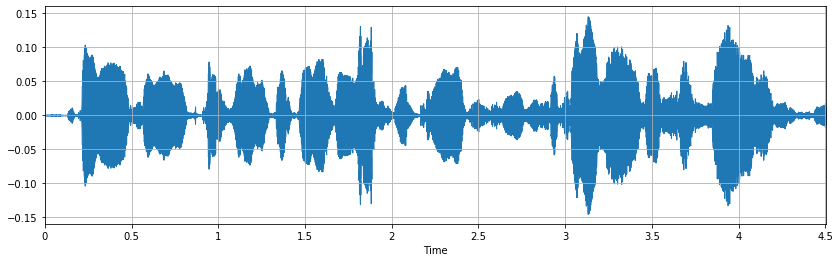

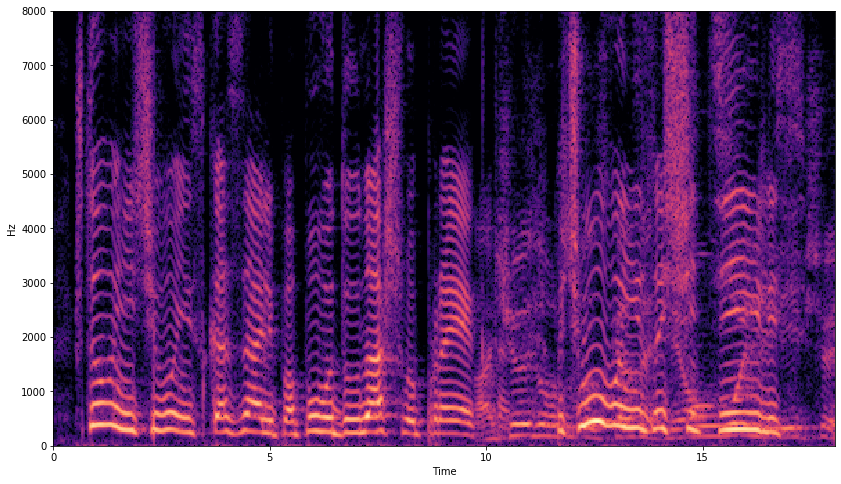

In [5]:
f_name = './spec_expl.wav'

play_wav(f_name)
show_wav(f_name)
spec = show_spec(f_name)

In [8]:
from librosa.core import fft_frequencies
from librosa.filters import mel

from sklearn.preprocessing import MinMaxScaler

Переход к мел шкале от частоты
$$ mel = 2595 \ln(1 + {{freq}\over{700}}) $$

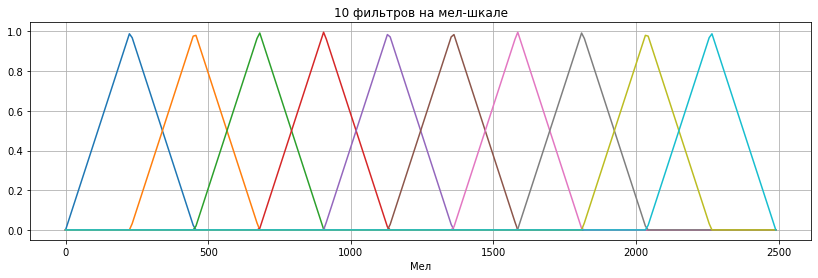

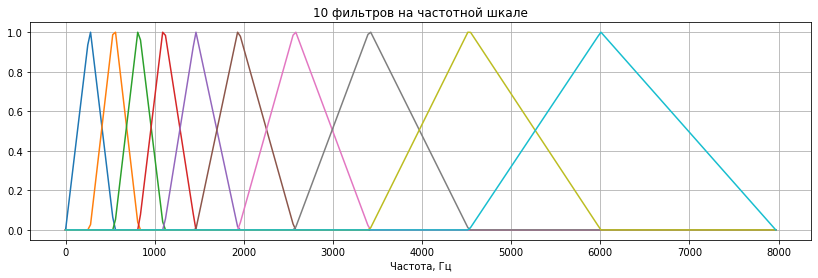

In [12]:
def freq_to_mel(f):
    return 2595.0 * np.log10(1.0 + f / 700.0)

n_mels_demo = 10
# ---------------------
# Код, выдернутый из функции mel (https://librosa.github.io/librosa/_modules/librosa/filters.html#mel)
# для визуализации линейного размещения мел фильтров на мел оси
max_mel = freq_to_mel(sample_rate//2)
mel_f = np.linspace(0, sample_rate//2, n_mels_demo + 2)

weights = np.zeros((n_mels_demo, int(1 + fft_size // 2)))

fftfreqs = fft_frequencies(sr=sample_rate, n_fft=fft_size)
fdiff = np.diff(mel_f)
ramps = np.subtract.outer(mel_f, fftfreqs)

for i in range(n_mels_demo):
    # lower and upper slopes for all bins
    lower = -ramps[i] / fdiff[i]
    upper = ramps[i+2] / fdiff[i+1]

    # .. then intersect them with each other and zero
    weights[i] = np.maximum(0, np.minimum(lower, upper))
# ---------------------

# Рисуем полученные фильтры на мел шкале
plt.figure(figsize=(14, 4))
plt.title('{} фильтров на мел-шкале'.format(n_mels_demo))
for f in weights:
    plt.plot(f)
plt.xlabel('Мел')
plt.grid()
freq_labels = [freq for freq in range(0, int(max_mel), 500)]
plt.xticks(ticks=np.linspace(0, fft_size//2 + 1, len(freq_labels)), labels=freq_labels)
plt.show()

# Рисуем полученные фильтры на частотной шкале
mel_matrix = mel(sr=sample_rate, n_fft=fft_size, n_mels=n_mels_demo)
# делаем фильтры "высотой" единица
mel_matrix = MinMaxScaler().fit_transform(mel_matrix.T).T

plt.figure(figsize=(14, 4))
plt.title('{} фильтров на частотной шкале'.format(n_mels_demo))
for f in mel_matrix:
    plt.plot(f)
plt.grid()
plt.xlabel('Частота, Гц')
freq_labels = [freq for freq in range(0, sample_rate//2 + 1, 1000)]
plt.xticks(ticks=np.linspace(0, fft_size//2 + 1, len(freq_labels)), labels=freq_labels)
plt.show()

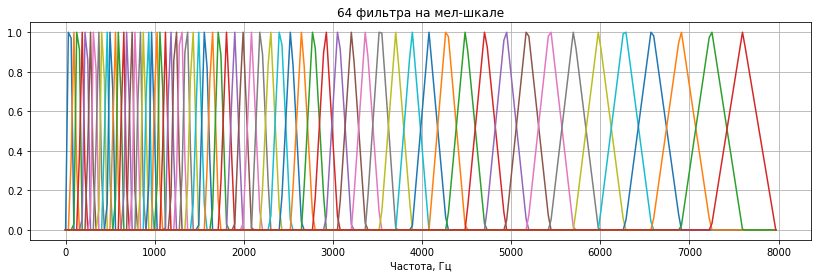

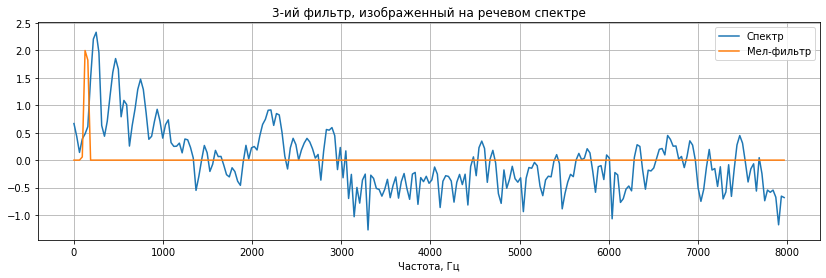

In [19]:
# теперь возьмем побольше фильтров, нарисуем один из первых на спектре речевого фрагмента нашей вавки
mel_matrix = mel(sr=sample_rate, n_fft=fft_size, n_mels=n_mels)
mel_matrix_ = MinMaxScaler().fit_transform(mel_matrix.T).T

# Рисуем полученные фильтры на частотной шкале
plt.figure(figsize=(14, 4))
plt.title('{} фильтра на мел-шкале'.format(n_mels))
for f in mel_matrix_:
    plt.plot(f)
plt.grid()
plt.xlabel('Частота, Гц')
freq_labels = [freq for freq in range(0, sample_rate//2 + 1, 1000)]
plt.xticks(ticks=np.linspace(0, fft_size//2 + 1, len(freq_labels)), labels=freq_labels)
plt.show()

# отдельный фильтр вместе со спектром
second_filter = mel_matrix_[2]
spec_part = np.log10(np.abs(spec[:, 100]))
spec_part -= spec_part.mean()

plt.figure(figsize=(14, 4))
plt.plot(spec_part, label='Спектр')
plt.title('3-ий фильтр, изображенный на речевом спектре')
plt.plot(second_filter*2, label='Мел-фильтр')
plt.legend()
plt.grid()
plt.xlabel('Частота, Гц')
freq_labels = [freq for freq in range(0, sample_rate//2 + 1, 1000)]
plt.xticks(ticks=np.linspace(0, fft_size//2 + 1, len(freq_labels)), labels=freq_labels)

plt.show()

In [20]:
print(mel_matrix.shape)
print(spec.shape)

mel_spec = np.dot(mel_matrix, spec)

(64, 257)
(257, 564)


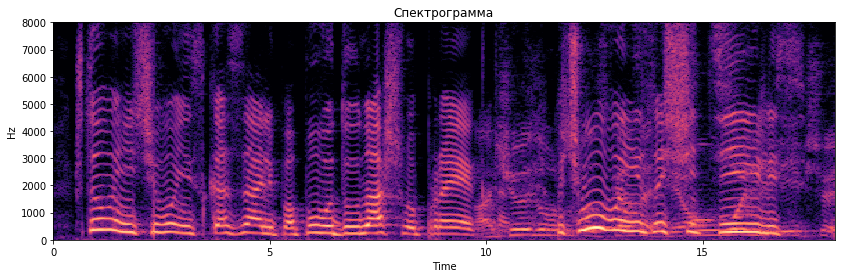

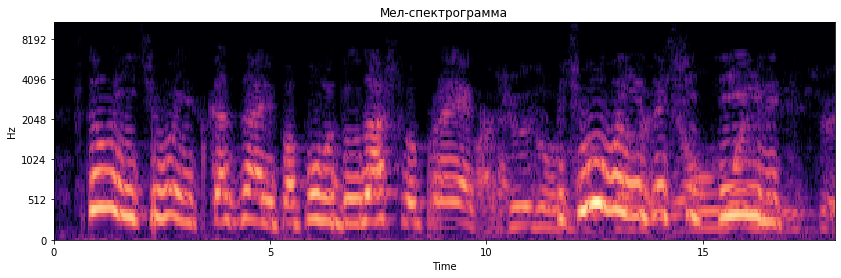

In [21]:
spec_db = amplitude_to_db(abs(spec))
plt.figure(figsize=(14, 4))
specshow(spec_db, sr=sample_rate, x_axis='time', y_axis='hz')
plt.title('Спектрограмма')
plt.show()

mel_spec_db = amplitude_to_db(abs(mel_spec))
plt.figure(figsize=(14, 4))
plt.title('Мел-спектрограмма')
specshow(mel_spec_db, sr=sample_rate, x_axis='time', y_axis='mel')
plt.show()


# MFCC

In [22]:
from scipy.fftpack import dct

$$ y_k = 2 \sum\limits_{n=0}^{N-1} x_n \cos{{\pi k (2 n + 1)}\over{2 N}} $$

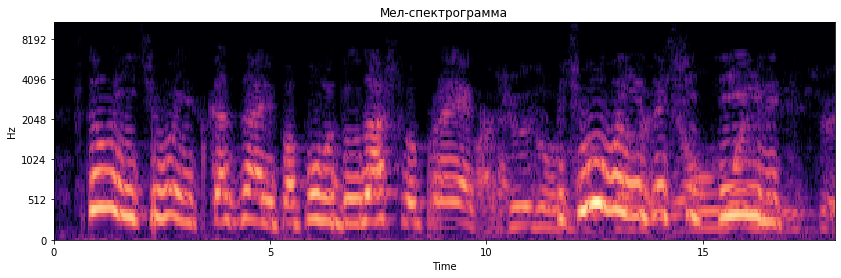

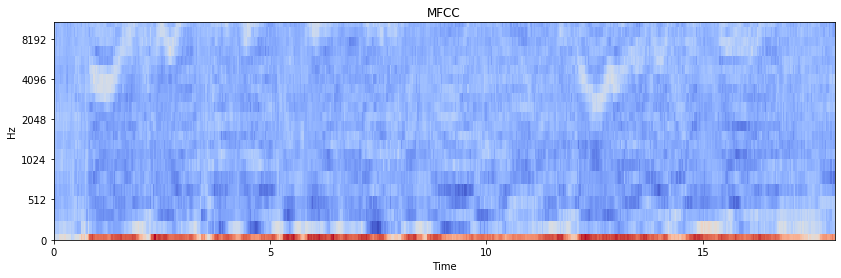

In [23]:
mfcc = dct(mel_spec_db, axis=0)
plt.figure(figsize=(14,4))
plt.title('Мел-спектрограмма')
specshow(mel_spec_db, sr=sample_rate, x_axis='time', y_axis='mel')
plt.show()

plt.figure(figsize=(14,4))
plt.title('MFCC')
specshow(mfcc[1:23, :], sr=sample_rate, x_axis='time', y_axis='mel')
plt.show()

In [ ]:
# SFF спектр

# sincnet

# filter bank learning